In [1]:
import autoreload
from ray.tune.analysis import Analysis
import pandas as pd
import multiprocessing
from ap_rllib.make_video import make_video, parser
import ray
import shutil
from IPython.display import display, FileLink
from matplotlib import pyplot as plt
from ap_rllib_experiment_analysis.bursts_analysis import burst_sizes, fill_which_training, iterate_bursts
from ap_rllib_experiment_analysis.analysis_helpers import get_scores, get_df_from_logdir
import numpy as np
import matplotlib.colors as mcolors
import pickle

In [2]:
# need ray for parallel evaluation
ray.shutdown()
ray.init(num_cpus=28, ignore_reinit_error=True, log_to_driver=False)

2020-10-12 13:23:44,844	INFO resource_spec.py:212 -- Starting Ray with 38.04 GiB memory available for workers and up to 19.03 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-10-12 13:23:44,966	WARNING services.py:923 -- Redis failed to start, retrying now.
2020-10-12 13:23:45,198	WARNING services.py:923 -- Redis failed to start, retrying now.
2020-10-12 13:23:45,687	INFO services.py:1165 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '128.32.175.9',
 'raylet_ip_address': '128.32.175.9',
 'redis_address': '128.32.175.9:43793',
 'object_store_address': '/tmp/ray/session_2020-10-12_13-23-44_835002_21925/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-10-12_13-23-44_835002_21925/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-10-12_13-23-44_835002_21925'}

2020-10-12 13:23:46,925	WARNING worker.py:1047 -- The dashboard on node astar failed with the following error:
Traceback (most recent call last):
  File "/scratch/sergei/miniconda3/lib/python3.7/site-packages/ray/dashboard/dashboard.py", line 960, in <module>
    metrics_export_address=metrics_export_address)
  File "/scratch/sergei/miniconda3/lib/python3.7/site-packages/ray/dashboard/dashboard.py", line 513, in __init__
    build_dir = setup_static_dir(self.app)
  File "/scratch/sergei/miniconda3/lib/python3.7/site-packages/ray/dashboard/dashboard.py", line 414, in setup_static_dir
    "&& npm run build)", build_dir)
FileNotFoundError: [Errno 2] Dashboard build directory not found. If installing from source, please follow the additional steps required to build the dashboard(cd python/ray/dashboard/client && npm ci && npm run build): '/scratch/sergei/miniconda3/lib/python3.7/site-packages/ray/dashboard/client/build'



In [3]:
# loading data
exp_name = "adversarial_tune_bursts_exp_sb"
config = "bursts_exp_sb"
analysis = Analysis("/home/sergei/ray_results/" + exp_name)
df = analysis.dataframe(metric='policy_reward_mean/player_1', mode=None)

In [4]:
SCORE_STEPS = 1# 15
VIDEO_STEPS = 1# 15

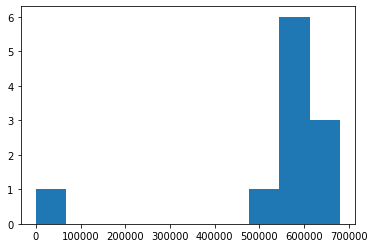

In [5]:
# removing short trials
plt.hist(df['episodes_total'])
df = df[df.episodes_total > 100000]

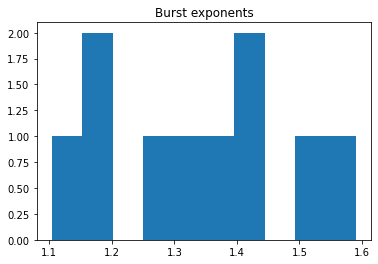

In [6]:
# All exponents
plt.title("Burst exponents")
plt.hist(df['config/_burst_exponent'])
plt.show()

In [7]:
def burst_background(rdf, trained_now, accumulator, rolling=10, state=None):
    """Add green-red bursts background."""
    min_metric, max_metric = state['min_metric'], state['max_metric']
    
    xs = accumulator['timesteps_total']
    
    colors_bg = {1: "red", 2: "green"}
    labels_bg = {1: "Training opponent", 2: "Training victim"}    
    
    plt.fill_between(xs, min_metric, max_metric, alpha=0.1, color=colors_bg[trained_now],
                     label=labels_bg[trained_now] if trained_now not in state else None)
    state[trained_now] = True
    
    return state


def burst_line_plot(rdf, trained_now, accumulator, rolling=10, state=None):
    """Plot lines from accumulator."""
    
    fields, colors, rolling = state['fields'], state['colors'], state['rolling']
    
    
    all_ys = {field: rdf[field] for field in fields}
    all_ys_roll = {f: pd.Series(all_ys[f]).rolling(rolling) for f in fields}
    all_ys_mean = {f: all_ys_roll[f].mean() for f in fields}
    all_ys_std = {f: all_ys_roll[f].std() for f in fields}

    min_metric = np.min([np.min(all_ys[f]) for f in fields])
    max_metric = np.max([np.max(all_ys[f]) for f in fields])

    
    xs = accumulator['timesteps_total']
    
    colors_bg = {1: "red", 2: "green"}
    labels_bg = {1: "Training opponent", 2: "Training victim"}

    
    for f in fields:
        ys = all_ys_mean[f][min(accumulator.index):max(accumulator.index) + 1]
        ys_std = all_ys_std[f][min(accumulator.index):max(accumulator.index) + 1]


        plt.plot(xs, ys, color=colors[f], alpha=1, label=f if 'legend_y' not in state else None)
        plt.fill_between(xs, ys - 3 * ys_std, ys + 3 * ys_std, color=colors[f], alpha=0.3)
    state['legend_y'] = True
    
    
    plt.fill_between(xs, min_metric, max_metric, alpha=0.1, color=colors_bg[trained_now],
                     label=labels_bg[trained_now] if trained_now not in state else None)
    state[trained_now] = True
    
    return state

cols = [x for x in mcolors.TABLEAU_COLORS]

In [8]:
@ray.remote(max_calls=1)
def make_video_1(*args, **kwargs):
    return make_video(*args, **kwargs)

def make_video_parallel(checkpoints, arguments):
    """Run make_video in parallel.
    
    Args:
        checkpoints: list of checkpoints to process
        arguments: list of strings to supply to the parser
        
    Returns:
        List of results from make_video
    
    """
    args = [parser.parse_args(['--checkpoint', ckpt, *arguments]) for ckpt in checkpoints]
    res = [make_video_1.remote(a) for a in args]
    res = ray.get(res)
    return res

def get_videos(df, steps=2, load_normal=False, display=':0', config=None):
    """Add video column to the dataframe."""
    args = ['--steps', str(steps), '--display', str(display), '--config', str(config)]
    if load_normal:
        args += ['--load_normal', 'True']
    res = make_video_parallel(list(df.checkpoint_rllib), args)
    r = [r['video'] for r in res]
    return r

def get_scores(df, steps=200, load_normal=False, config=None):
    """Compute scores w.r.t. all opponents."""
    # computing score with the normal opponent
    make_video_remote = ray.remote(make_video)
    args = ['--steps', str(steps), '--no_video', 'True', '--config', str(config)]
    if load_normal:
        args += ['--load_normal', 'True']
    res = make_video_parallel(list(df.checkpoint_rllib), args)
    return res

In [9]:
def process_trial_dataframe(rdf, fn="experiment"):


    # List of all players
    reward_prefix = 'policy_reward_mean/'
    POLICIES = [x[len(reward_prefix):] for x in rdf.columns if x.startswith(reward_prefix)]
    print("Policies:", POLICIES)

    exponent = rdf['config/_burst_exponent'][0]
    print("Exponent:", exponent)

    # filling the 'which_training' column
    rdf = fill_which_training(rdf, POLICIES)
    burst_sizes_ = burst_sizes(rdf['which_training'])

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Which player is trained?")
    plt.plot(rdf['timesteps_total'], rdf['which_training'])
    plt.xlabel('Timesteps')
    plt.subplot(1, 2, 2)
    plt.title(f"Burst sizes with exponent {round(exponent, 2)}")
    plt.plot(burst_sizes_)
    plt.xlabel('Burst number')
    plt.ylabel('Burst size')
    plt.savefig(fn + "_bursts.png", bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.xlabel('Timesteps')

    fields = [x for x in rdf.columns if x.startswith(reward_prefix)]

    iterate_bursts(rdf, burst_line_plot, state={'fields': fields,
                                                'colors': {f: cols[i] for i, f in enumerate(fields)},
                                                'rolling': 10})

    plt.legend()
    plt.savefig(fn + "_reward.png", bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.xlabel('Timesteps')

    fields = [x for x in rdf.columns if x.endswith('value_loss')]

    iterate_bursts(rdf, burst_line_plot, state={'fields': fields,
                                                'colors': {f: cols[i] for i, f in enumerate(fields)},
                                                'rolling': 10})

    plt.legend()
    plt.savefig(fn + "_loss.png", bbox_inches='tight')
    plt.show()


    # was there a switch?
    rdf['switch'] = list(np.array(rdf['which_training'].iloc[1:]) != rdf['which_training'].iloc[:-1]) + [True]

    rdf_e = rdf[rdf['switch'] == 1]
    print("To evaluate", len(rdf_e))

    # obtaining the scores


    scores_normal = get_scores(rdf_e, steps=SCORE_STEPS, load_normal=True, config=config)
    scores = get_scores(rdf_e, steps=SCORE_STEPS, load_normal=False, config=config)

    POLICIES_SHOW = list(POLICIES)
    if len(POLICIES_SHOW) == 2:
        POLICIES_SHOW = POLICIES_SHOW[0:1]

    # plotting the win rate
    plt.title("Win rate")
    for p in POLICIES_SHOW:
        plt.plot(rdf_e['timesteps_total'], [x[f"wins_policy_{p}_reward"] for x in scores], label=p + '_adversarial')
        plt.scatter(rdf_e['timesteps_total'][0], [x[f"wins_policy_{p}_reward"] for x in scores][0])
        plt.plot(rdf_e['timesteps_total'], [x[f"wins_policy_{p}_reward"] for x in scores_normal], label=p + '_normal')
        plt.scatter(rdf_e['timesteps_total'][0], [x[f"wins_policy_{p}_reward"] for x in scores_normal][0])
        assert all([x[f"ties_policy_{p}_reward"] == 0 for x in scores])
    plt.xlabel("Time-steps")

    iterate_bursts(rdf, burst_background, state={'min_metric': 0, 'max_metric': 100})

    plt.legend()
    plt.savefig(fn + "_win_rate.png", bbox_inches='tight')

    plt.show()

    videos_normal = get_videos(rdf_e, steps=VIDEO_STEPS, load_normal=True, config=config)
    videos = get_videos(rdf_e, steps=VIDEO_STEPS, load_normal=False, config=config)

    result = {'scores': scores, 'scores_normal': scores_normal,
              'videos': videos, 'videos_normal': videos_normal,
              'xs_e': rdf_e['timesteps_total'],
              'policies': POLICIES,
              'burst_sizes': burst_sizes_,
              'rdf': rdf,
              'rdf_e': rdf_e
             }
    
    return result

100%|██████████| 5001/5001 [00:08<00:00, 561.08it/s]


Policies: ['player_1', 'player_2']
Exponent: 1.3786340793523455


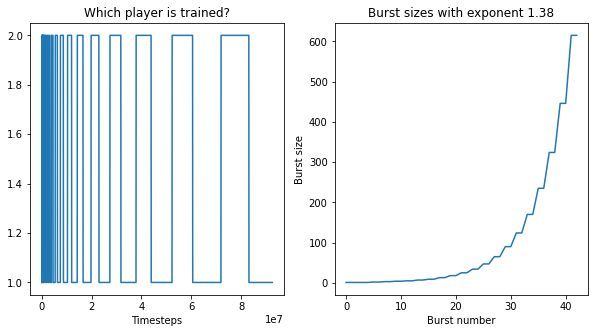

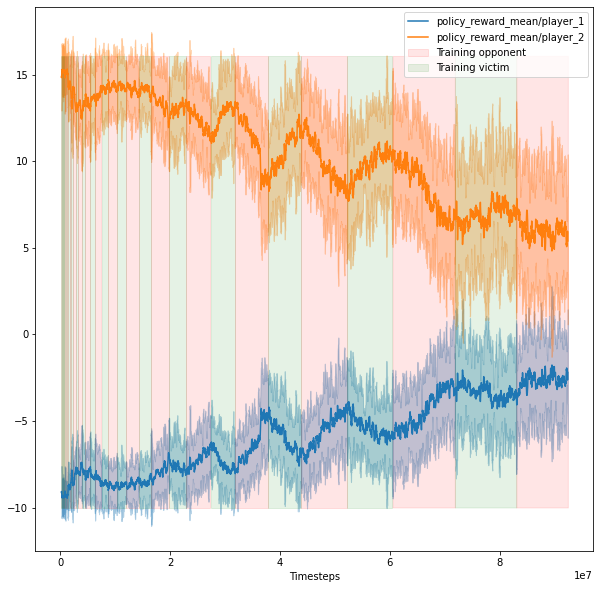

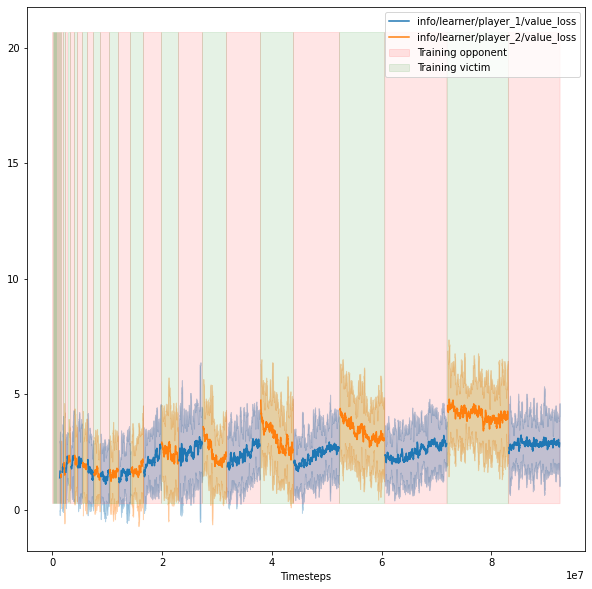

To evaluate 43


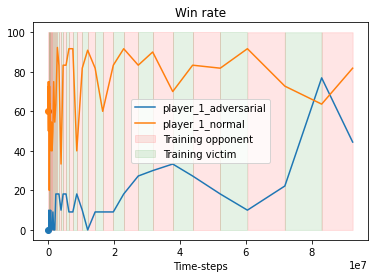

In [10]:
trial = df.iloc[0]
rdf = get_df_from_logdir(trial.logdir)
res = process_trial_dataframe(rdf)

In [ ]:
fns = []

for i, trial in df.iterrows():
    rdf = get_df_from_logdir(trial.logdir)
    fn = f"{exp_name}_trial_{str(i)}.pkl"
    res = process_trial_dataframe(rdf, fn)
    
    pickle.dump(res, open(fn, "wb"))
    fns.append(fn)

In [10]:
SCORE_STEPS = 15
VIDEO_STEPS = 15

In [21]:
i = 0
fns = []
fn = f"{exp_name}_trial_{str(i)}.pkl"
pickle.dump(res, open(fn, "wb"))
fns.append(fn)

In [22]:
!ls -la {fns[0]}

-rw-rw-r-- 1 sergei sergei 25707955 Sep 30 03:21 adversarial_tune_bursts_exp_sb_trial_0.pkl


In [11]:
import os
from tqdm import tqdm

In [12]:
def concat_videos(videos, out_fn):
    """Concatenate videos into one"""
    list_fn = "list_file.txt"
    with open(list_fn, 'w') as f:
        for video in videos:
            f.write(f"file {video}\n")
    os.system(f"ffmpeg -f concat -safe 0 -i {list_fn} -c copy {out_fn}.mp4")
    os.unlink(list_fn)

class VideosDownloader(object):
    """Download videos after re-naming them."""
    def __enter__(self):
        shutil.rmtree('videos/', ignore_errors=True)
        os.makedirs('videos', exist_ok=True)
        return self
        
    def __exit__(self, type_, value, traceback):
        os.system('zip -r videos.zip videos')
        local_file = FileLink('videos.zip', result_html_prefix="Download videos: ")
        display(local_file)
        
    def add_video(self, source, dest_filename):
        if not dest_filename.endswith('.mp4'):
            dest_filename = dest_filename + '.mp4'
        shutil.copyfile(source, f"videos/{dest_filename}")    

In [13]:
with VideosDownloader() as vd:

    for i, trial in tqdm(df.iterrows()):
        fn = f"{exp_name}_trial_{str(i)}.pkl"
        res = pickle.load(open(fn, "rb"))

        for j, video in enumerate(res['videos_normal']):
            vd.add_video(video, "trial_normal_%05d_ts_%09d.mp4" % (i, res['rdf_e'].timesteps_total.iloc[j]))
        
        for j, video in enumerate(res['videos']):
            vd.add_video(video, "trial_advers_%05d_ts_%09d.mp4" % (i, res['rdf_e'].timesteps_total.iloc[j]))

10it [06:00, 36.07s/it]


/scratch/sergei/better-adversarial-defenses/experiment_analysis/videos.zip

Policies: ['player_1', 'player_2']
Exponent: 1.3786340793523455
Policies: ['player_1', 'player_2']
Exponent: 1.1039564533118185


/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Policies: ['player_1', 'player_2']
Exponent: 1.538788061930423


/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Policies: ['player_1', 'player_2']
Exponent: 1.3031165533028628


/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Policies: ['player_1', 'player_2']
Exponent: 1.1554034868549017


/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Policies: ['player_1', 'player_2']
Exponent: 1.5906548203681832


/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Policies: ['player_1', 'player_2']
Exponent: 1.1669844886869163


/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Policies: ['player_1', 'player_2']
Exponent: 1.4292355550907312


/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Policies: ['player_1', 'player_2']
Exponent: 1.2502756346884454


/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Policies: ['player_1', 'player_2']
Exponent: 1.4395527524832088


/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


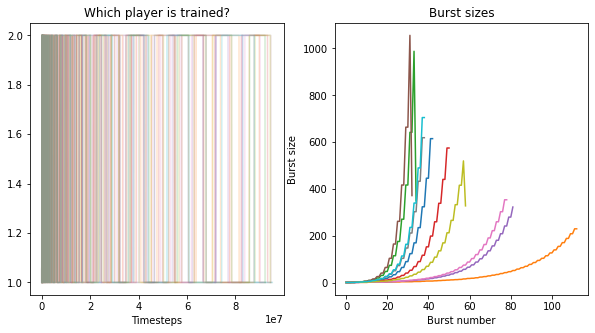

In [59]:
plt.figure(figsize=(10, 5))
for i, trial in df.iterrows():
    fn = f"{exp_name}_trial_{str(i)}.pkl"
    res = pickle.load(open(fn, "rb"))
    rdf = res['rdf']
    
    # List of all players
    reward_prefix = 'policy_reward_mean/'
    POLICIES = [x[len(reward_prefix):] for x in rdf.columns if x.startswith(reward_prefix)]
    print("Policies:", POLICIES)

    exponent = rdf['config/_burst_exponent'][0]
    print("Exponent:", exponent)

    # filling the 'which_training' column
    rdf = fill_which_training(rdf, POLICIES)
    burst_sizes_ = burst_sizes(rdf['which_training'])
    
    plt.subplot(1, 2, 1)
    plt.title("Which player is trained?")
    plt.plot(rdf['timesteps_total'], rdf['which_training'], alpha=0.2)
    plt.xlabel('Timesteps')
    plt.subplot(1, 2, 2)
    plt.title(f"Burst sizes")
    plt.plot(burst_sizes_)
    plt.xlabel('Burst number')
    plt.ylabel('Burst size')
plt.show()

To evaluate 43


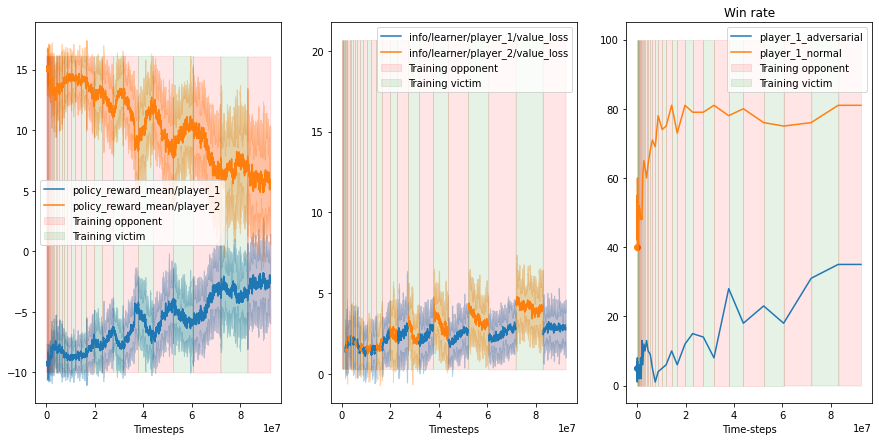

To evaluate 113


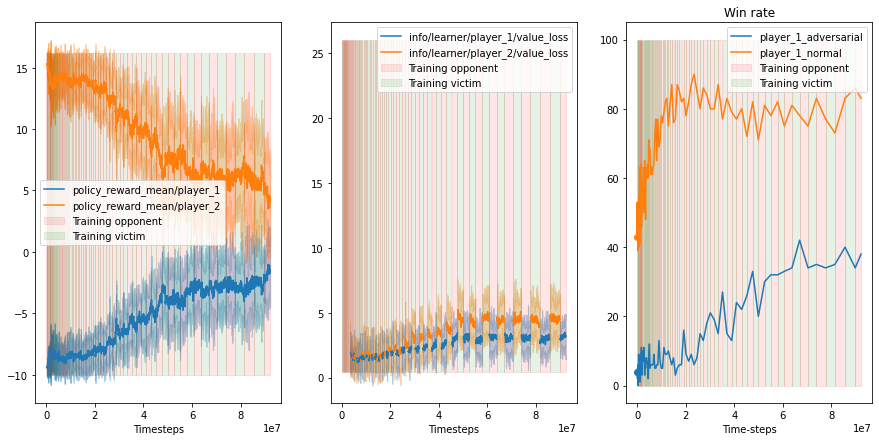

To evaluate 35


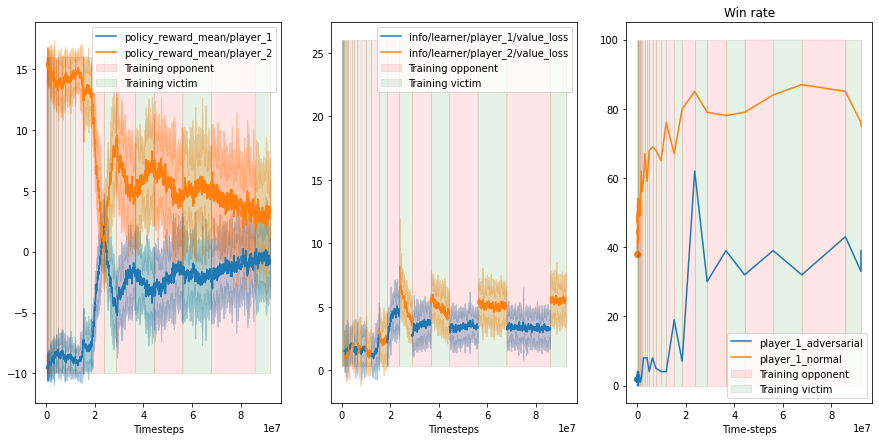

To evaluate 51


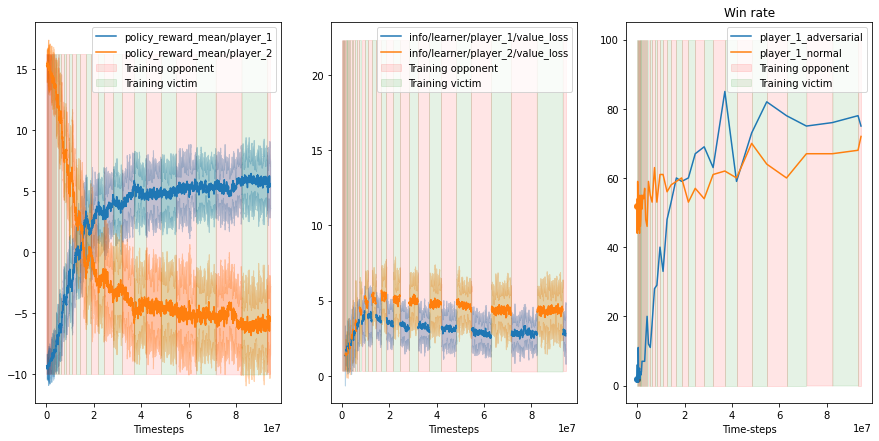

To evaluate 82


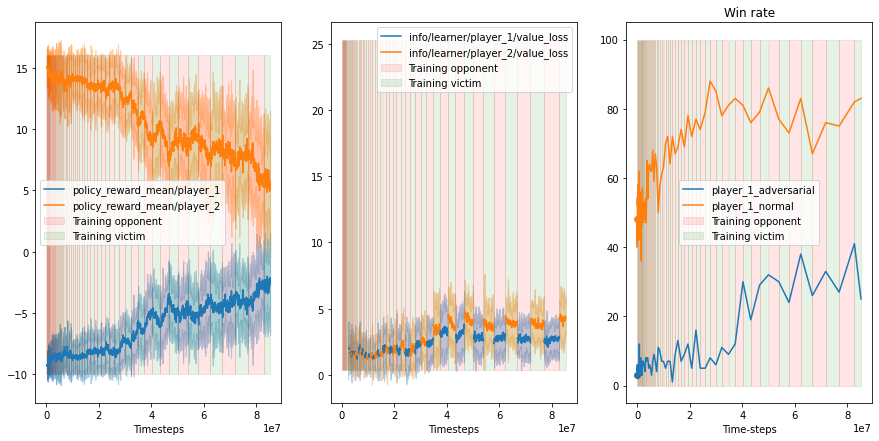

To evaluate 33


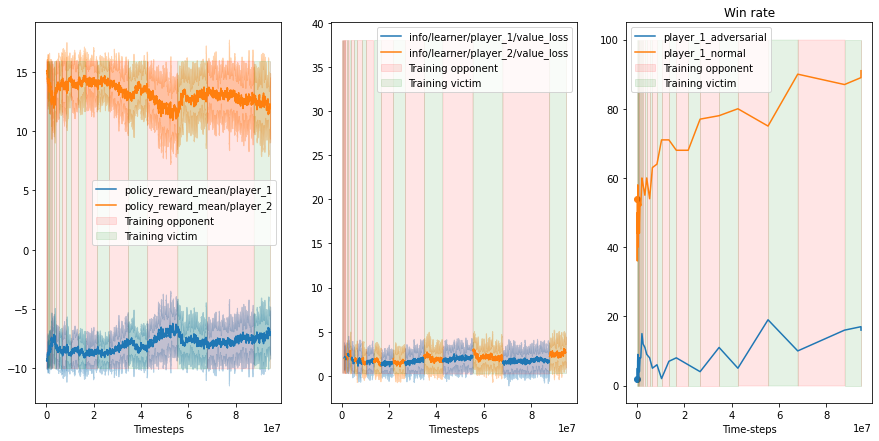

To evaluate 79


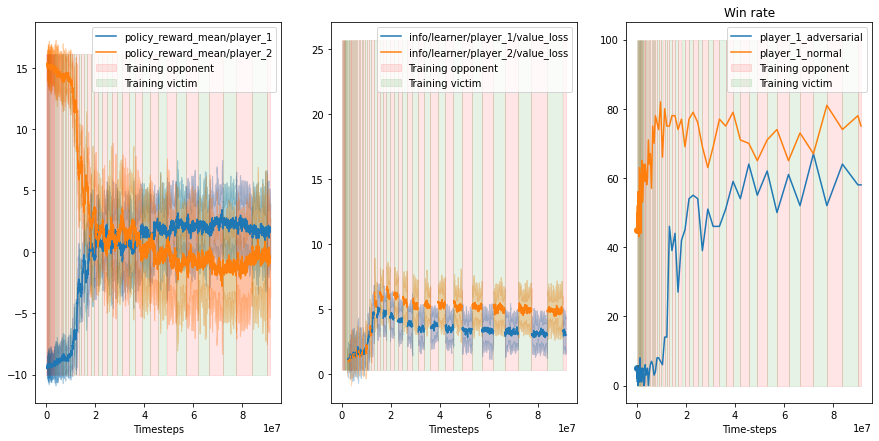

To evaluate 39


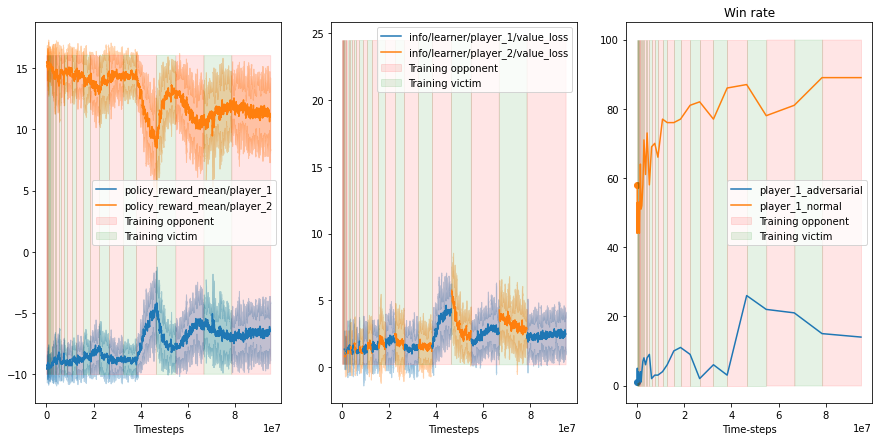

To evaluate 59


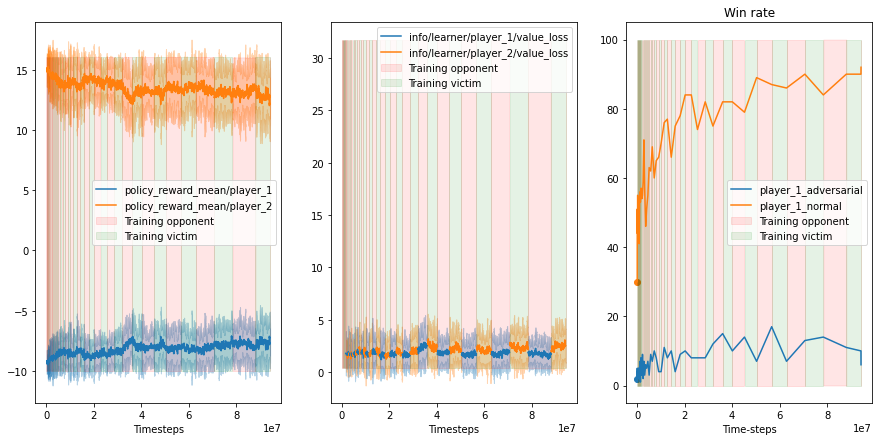

To evaluate 39


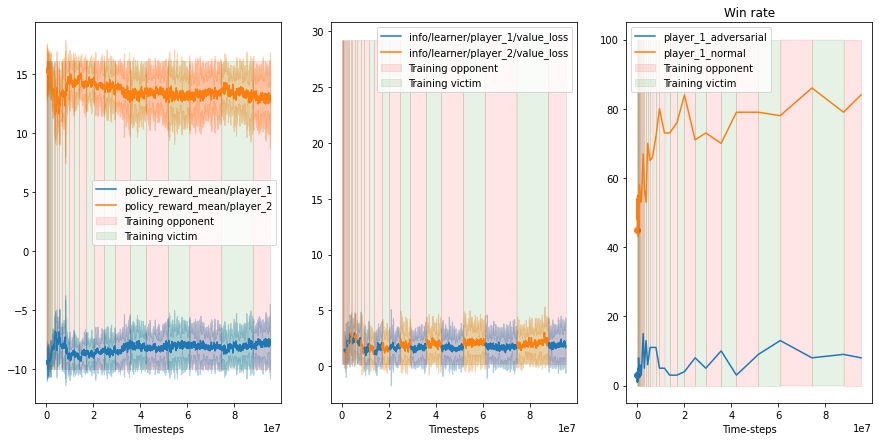

In [63]:
for i, trial in df.iterrows():
    fn = f"{exp_name}_trial_{str(i)}.pkl"
    res = pickle.load(open(fn, "rb"))
    rdf = res['rdf']

    plt.figure(figsize=(15, 7))
    plt.subplot(1, 3, 1)
    plt.xlabel('Timesteps')

    fields = [x for x in rdf.columns if x.startswith(reward_prefix)]

    iterate_bursts(rdf, burst_line_plot, state={'fields': fields,
                                                'colors': {f: cols[i] for i, f in enumerate(fields)},
                                                'rolling': 10})

    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.xlabel('Timesteps')

    fields = [x for x in rdf.columns if x.endswith('value_loss')]

    iterate_bursts(rdf, burst_line_plot, state={'fields': fields,
                                                'colors': {f: cols[i] for i, f in enumerate(fields)},
                                                'rolling': 10})

    plt.legend()
    plt.subplot(1, 3, 3)

    # was there a switch?
    rdf['switch'] = list(np.array(rdf['which_training'].iloc[1:]) != rdf['which_training'].iloc[:-1]) + [True]

    rdf_e = rdf[rdf['switch'] == 1]
    print("To evaluate", len(rdf_e))

    # obtaining the scores


    scores_normal = res['scores_normal']
    scores = res['scores']

    POLICIES_SHOW = list(POLICIES)
    if len(POLICIES_SHOW) == 2:
        POLICIES_SHOW = POLICIES_SHOW[0:1]

    # plotting the win rate
    plt.title("Win rate")
    for p in POLICIES_SHOW:
        plt.plot(rdf_e['timesteps_total'], [x[f"wins_policy_{p}_reward"] for x in scores], label=p + '_adversarial')
        plt.scatter(rdf_e['timesteps_total'][0], [x[f"wins_policy_{p}_reward"] for x in scores][0])
        plt.plot(rdf_e['timesteps_total'], [x[f"wins_policy_{p}_reward"] for x in scores_normal], label=p + '_normal')
        plt.scatter(rdf_e['timesteps_total'][0], [x[f"wins_policy_{p}_reward"] for x in scores_normal][0])
        assert all([x[f"ties_policy_{p}_reward"] == 0 for x in scores])
    plt.xlabel("Time-steps")

    iterate_bursts(rdf, burst_background, state={'min_metric': 0, 'max_metric': 100})

    plt.legend()
    plt.show()

In [70]:
def get_data(f):
    for i, trial in df.iterrows():
        fn = f"{exp_name}_trial_{str(i)}.pkl"
        res = pickle.load(open(fn, "rb"))
        yield f(res)
        
def get_data_win_rate():
    def f(res):
        return {'exponent': res['rdf']['config/_burst_exponent'][0],
                'win_adversary': res['scores'][-1]['wins_policy_player_1_reward'],
                'win_normal': res['scores_normal'][-1]['wins_policy_player_1_reward']
               }
    return pd.DataFrame(list(get_data(f)))

In [72]:
win_df = get_data_win_rate()

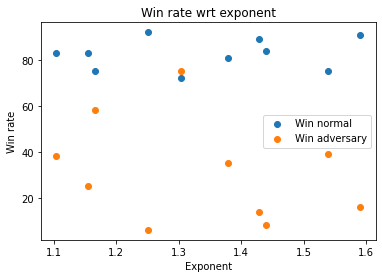

In [80]:
plt.title("Win rate wrt exponent")
plt.scatter(win_df['exponent'], win_df['win_normal'], label='Win normal')
plt.scatter(win_df['exponent'], win_df['win_adversary'], label='Win adversary')
plt.xlabel('Exponent')
plt.ylabel('Win rate')
plt.legend()
plt.show()

In [82]:
res['rdf']['which_training']

0       1
1       2
2       1
3       2
4       1
       ..
4996    1
4997    1
4998    1
4999    1
5000    1
Name: which_training, Length: 5001, dtype: int64